In [1]:
# Import modules
# ipython magic to plot in line
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
#matplotlib.style.use('ggplot')
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import time
plt.rcParams.update({'figure.max_open_warning': 0})

# On Chinook (in CST) we need to tell python we want to display in CST (otherwise UTC is assumed)
if os.name=='posix': # Linux
    os.environ['TZ'] = 'CST'
    time.tzset()

In [2]:
Stations_all = ['BNS','CRG','CRN','FLG','FRG','FRS','PWL']
Station_full_names = ['Bonsai','Can. Ridge','Can. Ridge North','Fortress Ledge','Fortress Ridge','Fortress Ridge South','Powerline']

CST_to_MST = -1 # CST to MST

In [3]:
# Set font size
font = {'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

In [4]:
# Directories
# Path to raw data
 # Win path
mod_dir   = os.path.normpath(r'C:\\Users\\new356\Model_Output\CHM\SnowCast')
telm_dir  = os.path.normpath(r'Y:\Centre\Marmot Creek\Telemetry\FortressMountain')
 # Linux path
#mod_dir   = os.path.normpath(r'/home/nwayand/snow_models/output_CHM/SnowCast')
#telm_dir  = os.path.normpath(r'/home/nwayand/hydrology_staff_readonly/Centre/Marmot Creek/Telemetry/FortressMountain')

# Model output ending
mod_ending   = '*_out.txt'

In [5]:
input_format = 'CHM'

In [6]:
if input_format == 'CHM':
    # Ascii data format info
    c_header = 1 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

In [7]:
# Move to Model dir
os.chdir(mod_dir) 

In [8]:
def get_recent_CRHO_data_from_telem(csta,data_dir):
    %matplotlib inline
    import os
    import numpy as np
    import pandas as pd
    from astropy.io import ascii

    c_header = 4 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

    # Load in file
    cfile = csta + '_0015.dat' # Format for 15 min file
    dat = ascii.read(os.path.join(data_dir,cfile),header_start=c_column_line,data_start=c_header,delimiter=c_delimiter,exclude_names='N/A')
    datain = pd.DataFrame(dat.as_array())

    # Replace -9999 with nan (recomended by netcdf)
    datain.replace(-9999,np.NaN,inplace=True)

    # Make TIMESTAMP the index
    datain['TIMESTAMP'] = datain['TIMESTAMP'].astype('datetime64[ns]')
    datain = datain.set_index('TIMESTAMP')
    
    
    # Telem files saved in CST, convert to MST
    datain.index = datain.index + datetime.timedelta(hours=CST_to_MST)
    # Adjust to local time zone (i.e. from UTC to MST, local_time_offset should = -7)
    #ds['datetime'] = pd.to_datetime(ds.datetime.values) + datetime.timedelta(hours=local_time_offset)
    
    # Import header info 
    headerinfo = pd.read_csv(os.path.join(data_dir,cfile),nrows=2,skiprows=1)
    units = headerinfo.loc[0,:].tolist() # Grab first row of dataframe (units)
    units = units[1:] # Remove first value which is the units of the timestamp

    return {'datain':datain, 'units':units}

In [9]:
def Scatter_plot(modData,obsData_dict,cclr,axes_var):
    #### Var to plot

    # Model
    t = modData['t']  # C
    p = modData['p']  # mm/1hr
    U_2m_srf = modData['U_2m_above_srf']
    #p_snow = modData['p_snow'] # mm/1hr
    #p_cum = p.cumsum()
    #p_snow_cum = p_snow.cumsum()
    ctime = t.index

    # Observed
    obsData = obsData_dict['datain']
    obsUnits = obsData_dict['units'] 
    obs_t_hrly = obsData['AirTemp_Avg'].resample('H',label='right').mean() # C
    if 'WindSpeed_S_WVT' in obsData:
        obs_WS_A_hrly = obsData['WindSpeed_S_WVT'].resample('H',label='right').mean() # m/s
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        obs_p = obsData['Accumulated_Total_NRT'] # mm # need to convert to incremental
        obs_pdiff = obs_p.diff(1) # convert to mm/15min (pandas pads first value as nan!)
        obs_pdiff[obs_pdiff<0] = 0
        obs_pdiff_hrly = obs_pdiff.resample('H',label='right').sum()
        #obs_pdiff_hrly_cum = obs_pdiff_hrly.cumsum()
    #obs_p_snow = modData['p_snow']    
    obs_ctime = obs_t_hrly.index

    # Find common dates
    com_hrs = np.intersect1d(obs_t_hrly.index,t.index)

    # Air temperature
    axes_var[0].scatter(t.ix[com_hrs],obs_t_hrly.ix[com_hrs],color=cclr)
    
    # Precipitaiton
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        axes_var[1].scatter(p.ix[com_hrs],obs_pdiff_hrly.ix[com_hrs],color=cclr)
        
    # Wind speed
    if 'WindSpeed_S_WVT' in obsData:
        axes_var[2].scatter(U_2m_srf.ix[com_hrs],obs_WS_A_hrly.ix[com_hrs],color=cclr)


In [10]:
# Color list
cl = ['b','g','r','c','m','y','k']

In [11]:
# For Each station

# Initalize plots

# Air temperature
fig1 = plt.figure()
fig1.set_size_inches(6, 6,forward=True)
axe_t = fig1.add_subplot(111,aspect='equal')
plt.title('Air Temperature')
c_min = -5
c_max = 22
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Precipitation
fig2 = plt.figure()
fig2.set_size_inches(6, 6,forward=True)
axe_p = fig2.add_subplot(111,aspect='equal')
plt.title('Incremental Precipitation')
c_min = 0
c_max = 10
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Wind Speed
fig3 = plt.figure()
fig3.set_size_inches(6, 6,forward=True)
axe_ws = fig3.add_subplot(111,aspect='equal')
plt.title('Wind Speed near surface...')
c_min = 0
c_max = 16
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

ctr = 0;
for cSta,staname in zip(Stations_all,Station_full_names):
    #print(staname)
    ###### Import model output file
    cfile = cSta + '_out.txt'
    
    # Import data to pandas dataframe
    modData = pd.read_csv(cfile,sep=",",parse_dates=True) 
    modData.set_index('datetime',inplace=True)

    # Make datetime the index
    modData.index = pd.to_datetime(modData.index)
    
    # Get Telem Observation data
    obsData = get_recent_CRHO_data_from_telem(cSta,telm_dir)

    ###########################
    # Plot 
    ###########################
    
    Scatter_plot(modData,obsData,cl[ctr],[axe_t,axe_p,axe_ws])
    
    #plt.show()
    
    ctr = ctr + 1
    

In [12]:
Station_full_names

['Bonsai',
 'Can. Ridge',
 'Can. Ridge North',
 'Fortress Ledge',
 'Fortress Ridge',
 'Fortress Ridge South',
 'Powerline']

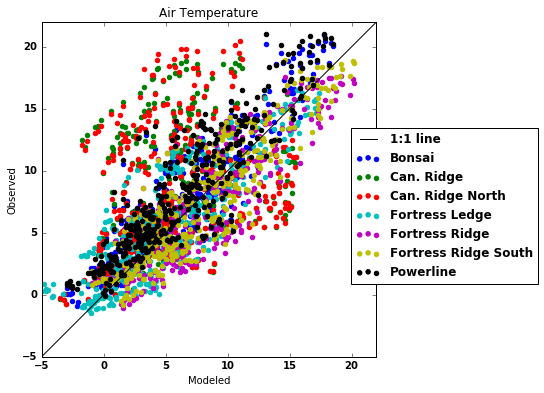

In [13]:
# Add Legends and plot
Station_full_names.insert(0,'1:1 line')

# Air Temperature
axe_t.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig1

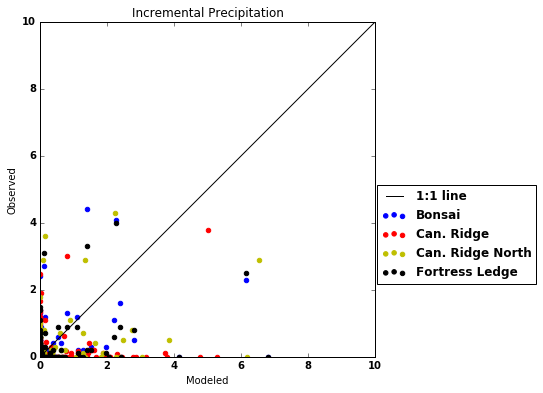

In [14]:
# Precipitation
axe_p.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig2

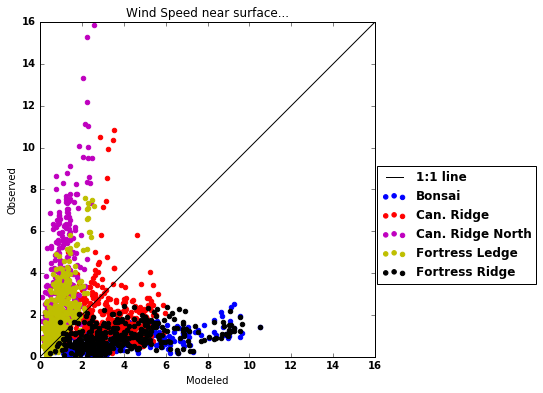

In [15]:
# Wind Speed 
axe_ws.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig3

In [16]:
return

SyntaxError: 'return' outside function (<ipython-input-16-64672a10de46>, line 1)

In [ ]:
obsData_dict = obsData

In [ ]:


#### Var to plot

# Model
t = modData['t']  # C
p = modData['p']  # mm/1hr
p_snow = modData['p_snow'] # mm/1hr
#p_cum = p.cumsum()
#p_snow_cum = p_snow.cumsum()
ctime = t.index

# Observed
obsData = obsData_dict['datain']
obsUnits = obsData_dict['units'] 
obs_t_hrly = obsData['AirTemp_Avg'].resample('H',label='right').mean() # C
if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
    obs_p = obsData['Accumulated_Total_NRT'] # mm # need to convert to incremental
    obs_pdiff = obs_p.diff(1) # convert to mm/15min (pandas pads first value as nan!)
    obs_pdiff[obs_pdiff<0] = 0
    obs_pdiff_hrly = obs_pdiff.resample('H',label='right').sum()
    obs_pdiff_hrly_cum = obs_pdiff_hrly.cumsum()
#obs_p_snow = modData['p_snow']    
obs_ctime = obs_t_hrly.index

# Find common dates
com_hrs = np.intersect1d(obs_t_hrly.index,t.index)

# Make figure handels if first time
if 'fig1' not in locals():
    fig1 = plt.figure()
    fig1.set_size_inches(6, 6,forward=True)
    axe1 = fig1.add_subplot(111,aspect='equal')
    plt.title('Air Temperature')


# Air temperature
plt.scatter(t.ix[com_hrs],obs_t_hrly.ix[com_hrs])
c_min = np.min([t.min(),obs_t_hrly.min()])
c_max = np.max([t.max(),obs_t_hrly.max()])
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
#plt.show()